In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime,date,timedelta,timezone

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.exceptions import NotFound
from google.api_core.exceptions import BadRequest


from ta.utils import dropna
import ta.trend as ta_trend
import ta.momentum as ta_mmt
import ta.others as ta_other
import ta 
#https://github.com/bukosabino/ta


import yfinance as yf
#https://github.com/ranaroussi/yfinance

# Often when people are talking about the stock market, 
# they're referring to US exchanges – such as the NYSE or NASDAQ – which are open from 14.30 to 21:00 (UTC)

In [143]:
# import functions_framework
# @functions_framework.http
# def load_asset_price_yahoo(request):

# Enviroment Variable 

In [9]:
start_date=os.environ.get('START_DATE', '')  # First recoud 
end_date=os.environ.get('END_DATE', '') 

# start_date=os.environ.get('START_DATE', '2022-12-01')
# end_date=os.environ.get('END_DATE', '2023-05-31') 

symbol_str_list=os.environ.get('SYMBOL_STR_LIST', 'QQQ')
#symbol_str_list=os.environ.get('SYMBOL_STR_LIST', 'SPY,QQQ,ACWI') # S&P500,NasDaq,World

nLastToIndy=int(os.environ.get('N_LAST_DATA', '45'))  # get data to calcualte EMA 


list_cols=['Date','Symbol','Close']

# Constant Value

In [25]:
source='yahoo'  # csv / yahoo
write_method='WRITE_APPEND'

ab_path="data/AB-QQQ_2014-12-01_NOW.csv" # if  load csv

# my_tz='Asia/Bangkok'
#write_method='WRITE_EMPTY' #'WRITE_TRUNCATE'

In [26]:
symbol_list= symbol_str_list.split(',')
print(symbol_list)


['QQQ']


In [27]:
import_dt=datetime.now(timezone.utc)
#import_dt=datetime.now(pytz.timezone(my_tz))
#import_dt=datetime.now(pytz.utc)

if  start_date=='' and end_date=='':
  start_date=(import_dt+timedelta(days=-1)).strftime("%Y-%m-%d")
  end_date= import_dt.strftime("%Y-%m-%d")
  # end_date=start_date  

if source=='yahoo':
 print(f" {source} Mode  : Get {symbol_list} from {start_date} to {end_date} at {import_dt}" ) 
else:
  print(f"{source} Mode  : Get {symbol_list} from {ab_path}" )    

 yahoo Mode  : Get ['QQQ'] from 2023-06-08 to 2023-06-09 at 2023-06-09 15:11:12.198571+00:00


# BigQuery

In [28]:
projectId="pongthorn"
dataset_id='FinAssetForecast'
table_data_id=f"{projectId}.{dataset_id}.fin_data"
print(table_data_id)

client = bigquery.Client(project=projectId )

def load_data_bq(sql:str):
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df


def importDataToBQ(dfToBQ):
    try:
            job_config = bigquery.LoadJobConfig(
                write_disposition=write_method,
            )
            job = client.load_table_from_dataframe(
                dfToBQ, table_data_id, job_config=job_config,
            )  # Make an API request.
            job.result()  # Wait for the job to complete.
            print(f"{source}-Total", len(dfToBQ), f" Add transaction to {table_data_id} bigquery successfully")
    except:
          print(job.error_result)

pongthorn.FinAssetForecast.fin_data


# Build Indicator as Feature using TA-Lib

In [29]:
def build_indicator_feature(df):
    # df['MA5d']=ta_trend.sma_indicator(close=df['Close'],window=5,fillna=True).round(4)
    df['EMA1']=ta_trend.ema_indicator(close=df['Close'],window=10,fillna=True).round(4)
    df['EMA2']=ta_trend.ema_indicator(close=df['Close'],window=20,fillna=True).round(4)
    df['MACD']=ta_trend.macd(close=df['Close'], window_slow=20, window_fast=10, fillna=True).round(4)
    df['SIGNAL']=ta_trend.macd_signal(close=df['Close'], window_slow=20, window_fast=10,window_sign=15, fillna=True).round(4)
    return df   

# Load Historical Price Exported  from Amibroker as CSV and save to BQ 

In [30]:
if source=='csv': # only one symbol
    print("Load data from CSV (Export from Amibroker)")
    '''
    Afl file on Amibroker  Explore to train TS 01-12-2014 - 31-05-2023
    Filter=1; 
    AddColumn(C,"close"); 
    '''
    # export form Amibroker exploration from 2014- the day prior to last record 
    #ab_path="data/AB-QQQ_2014-12-01_2023-06-06.csv" 
    
    dfCSV=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
    dfCSV.columns=['Symbol','Date','Close']
    dfCSV=dfCSV[list_cols]
    
    dfCSV=dfCSV.drop_duplicates(subset=['Date','Symbol'],keep='last')
    dfCSV=dfCSV.sort_values(by=['Date'])
    print(dfCSV.head())
    print(dfCSV.tail())
    
    dfCSV=build_indicator_feature(dfCSV)
    
    dfCSV['ImportDateTime']=import_dt
    
    print(dfCSV.info())
    print(dfCSV.head(10))
    print(dfCSV.tail(10))
    
    # for symbol in  dfCSV['Symbol'].unique():
    #      dfBySymbol=dfCSV.query(f'Symbol==@symbol')
    #      dfBySymbol.tail(10).to_csv(f"{symbol}-TA.csv",index=False)

    
    importDataToBQ(dfCSV)

# Load recent data from Yahoo

In [31]:
if source=='yahoo':
    
    print("Load data from Yahoo")
    
    dfMain=pd.DataFrame(columns=list_cols)
    print(dfMain)

    for symbol in symbol_list:
        
        print("Check already imported data")
        sqlLastItem=f"""
        select * from `{table_data_id}`  
        where Date>='{start_date}' and  Date<='{end_date}' and Symbol='{symbol}' """
        print(sqlLastItem)
        
        dfLastItem=load_data_bq(sqlLastItem)
        if dfLastItem.empty==False:
            print(f"Found {symbol} from {start_date} - {end_date} already")
            continue
            #return f"Found {symbol} from {start_date} - {end_date} already"
        else:
            print(f"It is about to load  {symbol} from {start_date} - {end_date}")
        print(f"========================================================")    
                
        print(f"Load {symbol} from {start_date} to {end_date} from yahoo")
        dfx=yf.download(tickers=symbol,start=start_date,end=end_date)
        print(dfx)
        print(f"========================================================")
        
#         if dfx.empty==False:
#             print(f"==============Transform {symbol} price data=============")  
#             dfx.reset_index(drop=False,inplace=True)  
#             dfx['Symbol']=symbol
#             dfx=dfx[['Date','Symbol','Close']] 
#             # print(dfx)

            
#             print(f"==============Pull {symbol} historical price data to calculate TA-Indicatory Feature=============")  
#             minDate=dfx['Date'].min().strftime("%Y-%m-%d")
#             print("First Row of Yahoo"+minDate)
#             sqlX=f"""
#             SELECT Date,Symbol,Close FROM `{table_data_id}` 
#             Where  Date between  DATE_SUB(DATE '{minDate}', INTERVAL {nLastToIndy} Day) and '{minDate}' 
#             and Symbol='{symbol}' order by Date,ImportDateTime
#             """
            
#             dfHist=load_data_bq(sqlX)      
#             # print(dfHist)

#             print("Append historical data over the past N day and recent data")
#             dfx=pd.concat([dfHist,dfx],axis=0,ignore_index=True)
            
            
#             print(dfx)
              
#             print(f"No {len(dfx)} past data+current to calculate TA-Indicator")
#             dfx=dfx.drop_duplicates(subset=['Date','Symbol'],keep='last')
#             dfx['Date']=pd.to_datetime(dfx['Date'],format='%Y-%m-%d')

#             dfx=build_indicator_feature(dfx)

#             print(dfx)
#             print(dfx.info())   
#             print(f"========================================================")

#             print("Filter out only recent data inluded TA-Feature") 
#             dfx=dfx[dfx.Date.between(start_date, end_date)]
#             dfx = dfx.query('Date >= @start_date and Date < @end_date')
#             print(dfx)
#             print(f"========================================================")
            
#             dfMain=pd.concat([dfMain,dfx])
            

#         else:
#           msg=f"Not found {symbol} OR No data between {start_date} and {end_date}"
#           print(msg)
#           #return  msg
        
#     #Ingest to BQ 
#     if dfMain.empty==False:
    
#         dfMain['ImportDateTime']=import_dt
#         #dfMain['ImportDateTime']=dfMain['ImportDateTime'].dt.tz_localize('utc').dt.tz_convert(my_tz)
        
#         print(dfMain.info())
#         print(dfMain)
#         importDataToBQ(dfMain)

Load data from Yahoo
Empty DataFrame
Columns: [Date, Symbol, Close]
Index: []
Check already imported data

        select * from `pongthorn.FinAssetForecast.fin_data`  
        where Date>='2023-06-08' and  Date<='2023-06-09' and Symbol='QQQ' 
Found QQQ from 2023-06-08 - 2023-06-09 already


In [82]:
# return 'OK'


# Visualize Chart 


SELECT * FROM `pongthorn.FinAssetForecast.fin_data` 
where (Date>='2023-04-24' and Date<='2023-06-09')
and Symbol='SPY'

           Symbol       Close      EMA1      EMA2    MACD  SIGNAL  \
Date                                                                
2023-06-02    SPY  427.920000  419.3935  416.6373  2.7562  1.7007   
2023-06-05    SPY  427.100000  420.7947  417.6338  3.1609  1.8832   
2023-06-06    SPY  428.030000  422.1102  418.6239  3.4863  2.0836   
2023-06-07    SPY  426.550000  422.9174  419.3788  3.5387  2.2655   
2023-06-08    SPY  429.130005  424.0486  420.4640  3.5845  2.0425   

                       ImportDateTime  
Date                                   
2023-06-02 2023-06-09 09:03:44.544436  
2023-06-05 2023-06-09 09:03:44.544436  
2023-06-06 2023-06-09 09:03:44.544436  
2023-06-07 2023-06-09 09:03:44.544436  
2023-06-08 2023-06-09 09:08:56.985848  


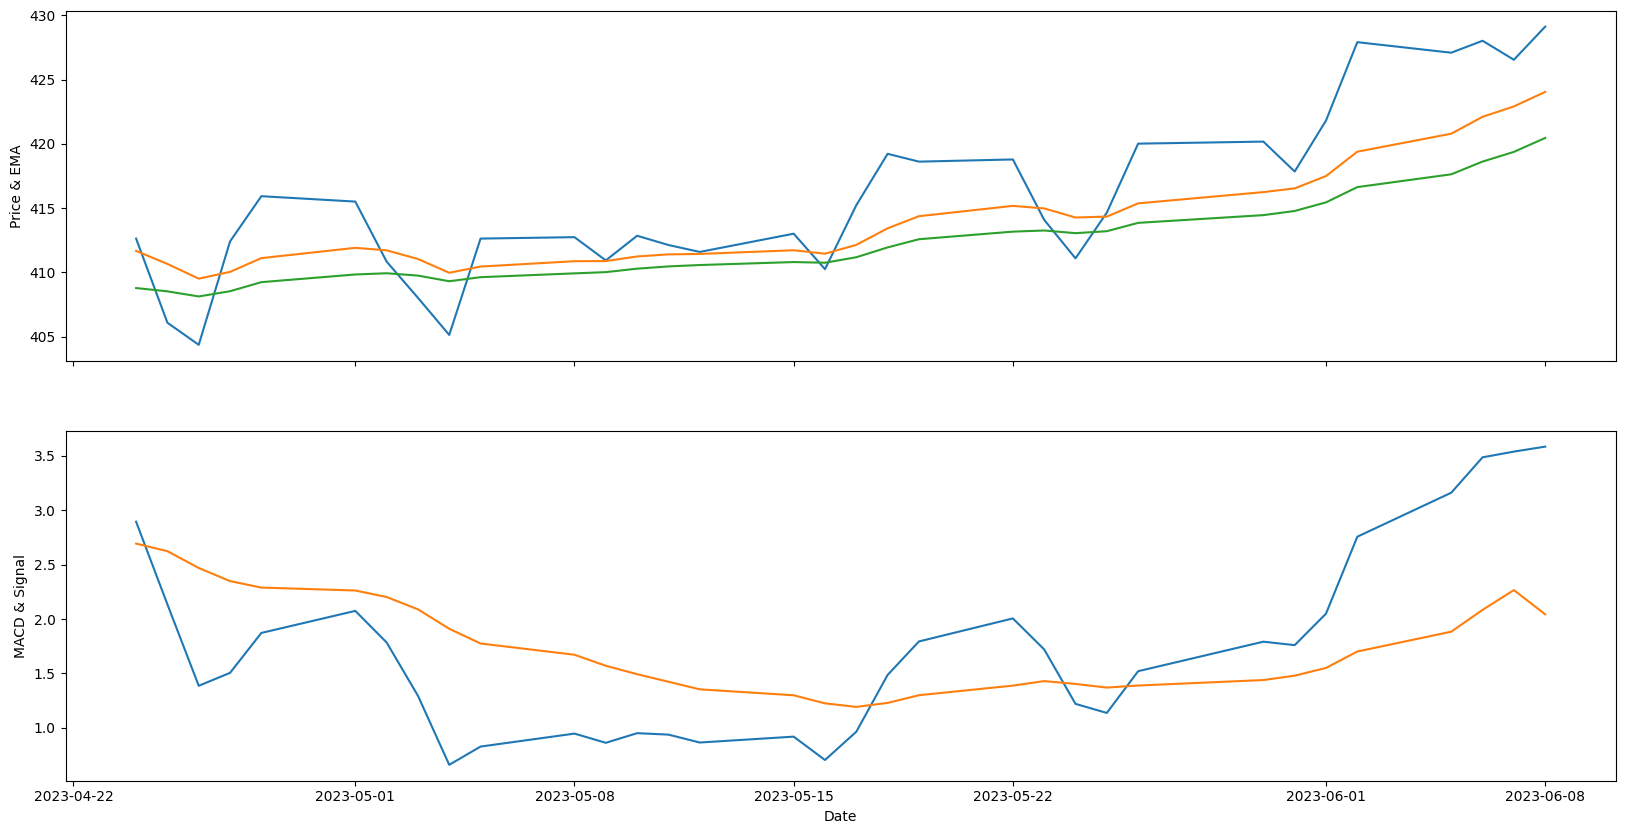

In [152]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
startPriceData='2023-04-24'  
endPriceData=datetime.now().strftime('%Y-%m-%d')
asset_name='SPY'

sqlData=f"""
SELECT * FROM `pongthorn.FinAssetForecast.fin_data` 
where (Date>='{startPriceData}' and Date<='{endPriceData}')
and Symbol='{asset_name}'
"""
print(sqlData)

dfData=load_data_bq(sqlData)
dfData=dfData.set_index('Date')
dfData=dfData.sort_index()
print(dfData.tail(5))

plt.subplots(2, 1, figsize = (20, 10),sharex=True)

ax1 = plt.subplot(2, 1, 1)
plt.plot(dfData.index,dfData[['Close','EMA1','EMA2']])
plt.ylabel('Price & EMA')

ax2 = plt.subplot(2, 1, 2)
plt.plot(dfData.index,dfData[['MACD','SIGNAL']])
plt.xlabel('Date')
plt.ylabel('MACD & Signal')

plt.show()